# Map Plots

This notebook makes the subplots used in figure 1 of Wenegrat et al. 2022, and the depth integrated maps for the supplementary information.

In [ ]:
%%capture
!apt-get install libproj-dev proj-data proj-bin
!apt-get install libgeos-dev
!pip install geoplot
!pip install gsw
!pip install xarray
!pip install netcdf4
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc
!pip install cmocean

In [ ]:
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import gsw
import pandas as pd
import matplotlib as mpl
import cmocean as cm
import os


### LOAD DATA

In [ ]:
# Pick which variable to use for all calculations
delv = 'delta_T_merged'
wodperiod = 'A5B7' #This is the modern climatogloy

#delv = 'delta_T_merged_5564'
#wodperiod = '5564'
cutlat = -90 # most Southern Latitude to include

In [ ]:
# Load the data
# test new load function
import sys
sys.path.insert(0,'/content/drive/My Drive/WOD Historic Data/Jacob Analysis/src')
from importlib import reload
import loadPickle as loadPickle
reload(loadPickle)
cruises_ds = loadPickle.loadPickle('/content/drive/My Drive/WOD Historic Data/ALL_CRUISES_v0p8.pkl', cutlat)
cruises_ds  


<xarray.Dataset>
Dimensions:                    (index: 534)
Coordinates:
  * index                      (index) int64 10 11 12 13 14 ... 615 616 617 618
Data variables: (12/40)
    Station                    (index) object '40' '40' '40' ... '181' '181'
    Date                       (index) datetime64[ns] 1874-10-08 ... 1906-08-14
    Lat degrees                (index) float64 -39.0 -39.0 -39.0 ... -9.0 -9.0
    Lat minutes                (index) float64 -9.5 -9.5 -9.5 ... -18.0 -18.0
    Lon degrees                (index) float64 20.0 20.0 20.0 ... 112.0 112.0
    Lon minutes                (index) float64 56.0 56.0 56.0 ... 9.0 9.0 9.0
    ...                         ...
    delta_T_seasonal_5564      (index) float64 -1.05 -1.454 ... -0.7273 -0.2845
    WOA_temp_seasonal_5564     (index) float64 18.15 16.85 15.55 ... 8.873 1.416
    delta_T_merged             (index) float64 -0.6061 -0.3704 ... -0.3018
    WOA_temp                   (index) float64 18.59 17.93 16.96 ... 8.995 1.398
    delta_T_merged_5564        (index) float64 -1.832 -1.609 ... -0.8942 -0.2845
    WOA_temp_5564              (index) float64 17.37 16.69 15.22 ... 8.706 1.416

In [ ]:
url=f'https://data.nodc.noaa.gov/thredds/dodsC/ncei/woa/temperature/A5B7/0.25/woa18_A5B7_t00_04.nc' # ARGO
WOD = xr.open_dataset(url, decode_times=False).t_an.squeeze()
WOD

<xarray.DataArray 't_an' (depth: 102, lat: 720, lon: 1440)>
[105753600 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * depth    (depth) float32 0.0 5.0 10.0 15.0 ... 5.3e+03 5.4e+03 5.5e+03
    time     float32 726.0
Attributes:
    standard_name:  sea_water_temperature
    long_name:      Objectively analyzed mean fields for sea_water_temperatur...
    cell_methods:   area: mean depth: mean time: mean within years time: mean...
    grid_mapping:   crs
    units:          degrees_celsius
    _ChunkSizes:    [  1  26 180 360]

###Create Depth-Integrated Plots for SI

In [ ]:
# surface

# surface
ds_0 = cruises_ds.where((cruises_ds.cruise=='Gazelle')& (cruises_ds.Depth <= 1.0), drop=True)
bin_0_G = ds_0.groupby('lat').mean()
ds_0 = cruises_ds.where((cruises_ds.cruise=='Valdivia')& (cruises_ds.Depth <= 1.0), drop=True)
bin_0_V = ds_0.groupby('lat').mean()
ds_0 = cruises_ds.where((cruises_ds.cruise=='Planet')& (cruises_ds.Depth <= 1.0), drop=True)
bin_0_P = ds_0.groupby('lat').mean()

# surface to 500 m
ds_0 = cruises_ds.where((cruises_ds.cruise=='Gazelle')& (cruises_ds.Depth >= -1.0) & (cruises_ds.Depth<=500.0), drop=True)
bin_500_G = ds_0.groupby('lat').mean()
ds_0 = cruises_ds.where((cruises_ds.cruise=='Valdivia')& (cruises_ds.Depth >= -1.0) & (cruises_ds.Depth<=500.0), drop=True)
bin_500_V = ds_0.groupby('lat').mean()
ds_0 = cruises_ds.where((cruises_ds.cruise=='Planet')& (cruises_ds.Depth >= -1.0) & (cruises_ds.Depth<=500.0), drop=True)
bin_500_P = ds_0.groupby('lat').mean()

# 500 m to 1000 m
ds_0 = cruises_ds.where((cruises_ds.cruise=='Gazelle')& (cruises_ds.Depth >= 500.0) & (cruises_ds.Depth<=1000.0), drop=True)
bin_1000_G = ds_0.groupby('lat').mean()
ds_0 = cruises_ds.where((cruises_ds.cruise=='Valdivia')& (cruises_ds.Depth >= 500.0) & (cruises_ds.Depth<=1000.0), drop=True)
bin_1000_V = ds_0.groupby('lat').mean()
ds_0 = cruises_ds.where((cruises_ds.cruise=='Planet')& (cruises_ds.Depth >= 500.0) & (cruises_ds.Depth<=1000.0), drop=True)
bin_1000_P = ds_0.groupby('lat').mean()

# 1000 m to 1500 m
ds_0 = cruises_ds.where((cruises_ds.cruise=='Gazelle')& (cruises_ds.Depth >= 1000.0) & (cruises_ds.Depth<=1500.0), drop=True)
bin_1500_G = ds_0.groupby('lat').mean()
ds_0 = cruises_ds.where((cruises_ds.cruise=='Valdivia')& (cruises_ds.Depth >= 1000.0) & (cruises_ds.Depth<=1500.0), drop=True)
bin_1500_V = ds_0.groupby('lat').mean()
ds_0 = cruises_ds.where((cruises_ds.cruise=='Planet')& (cruises_ds.Depth >= 1000.0) & (cruises_ds.Depth<=1500.0), drop=True)
bin_1500_P = ds_0.groupby('lat').mean()


#Total_cruise track
ds_0G = cruises_ds.sortby('Date').where((cruises_ds.cruise=='Gazelle'), drop=True)
bin_G = ds_0G.groupby('lat').mean()
ds_0V = cruises_ds.sortby('Date').where((cruises_ds.cruise=='Valdivia'), drop=True)
bin_V = ds_0V.groupby('lat').mean()
ds_0P = cruises_ds.where((cruises_ds.cruise=='Planet'), drop=True).sortby('Date')
bin_P = ds_0P.groupby('lat').mean()

This function makes the depth integrated maps of temperature anomaly

In [ ]:
def plot_roemmich_ds(dsG, dsV, dsP, WOD, ax, title, norm, cmap):
  

  #ax=plt.subplot(subplot,projection=ccrs.PlateCarree())
  ax.add_feature(cfeature.LAND, zorder=0, edgecolor='black', facecolor='gray')
  ax.set_xlim([10, 135])
  ax.set_ylim([-60, 30])

  gl = ax.gridlines(draw_labels=True, linestyle='--', linewidth=1)
  gl.xlabel_style = {'size': 12, 'color': 'black'}
  gl.ylabel_style = {'size': 12, 'color': 'black'}
  gl.right_labels = False
  gl.top_labels = False
  
  tempconts = np.arange(0, 36, 2)
  labelconts = np.arange(0, 36, 4)

  #print(tempconts)
  cs = ax.contour(WOD.lon, WOD.lat, WOD, tempconts, colors='0.5', linewidths=0.5, zorder=0)
  plt.clabel(cs, labelconts,fmt='%1.f')
  symbG = 'd'
  symbV = 'o'
  symbP = '^'
  s = 80

  points = ax.scatter(dsG.lon,dsG.lat, c=dsG[delv], s=s, marker=symbG, cmap=cmap,norm=norm, edgecolor='gray')
  points = ax.scatter(dsV.lon,dsV.lat, c=dsV[delv], s=s, marker=symbV, cmap=cmap,norm=norm, edgecolor='gray')
  points = ax.scatter(dsP.lon,dsP.lat, c=dsP[delv], s=s, marker=symbP, cmap=cmap,norm=norm, edgecolor='gray')

  #plt.colorbar(points, fraction = .034, pad = 0.02).set_label(label=u'Change in T (\N{DEGREE SIGN}C)', size=12)
  ax.set_title(title, fontsize=14)
  #ax.stock_img()
  return gl

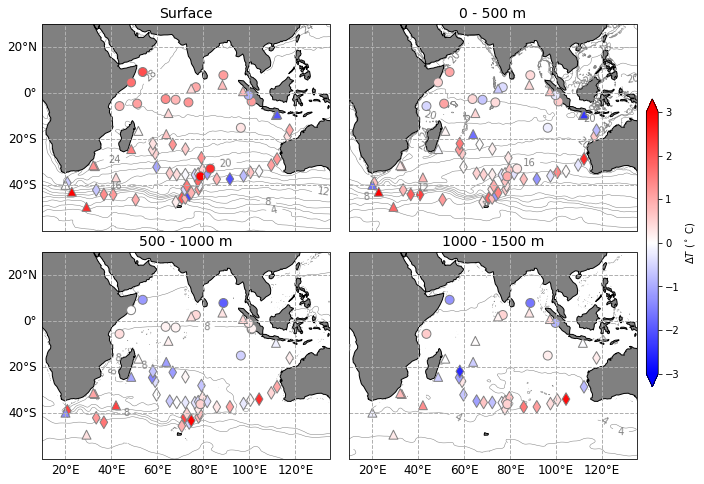

In [ ]:
# plot used in manuscript supplementary info
# 500 meter depth bins excluding the surface


norm = mpl.colors.Normalize(vmin=-3,vmax=3)
cmap = mpl.cm.coolwarm
cmap = mpl.cm.bwr
fig = plt.figure(figsize = (11, 8))
ax1 = plt.subplot(2,2,1, projection = ccrs.PlateCarree())
ax2 = plt.subplot(2,2,2, projection = ccrs.PlateCarree(), sharex=ax1, sharey=ax1)
ax3 = plt.subplot(2,2,3, projection = ccrs.PlateCarree(), sharex=ax1, sharey=ax1)
ax4 = plt.subplot(2,2,4, projection = ccrs.PlateCarree(), sharex=ax1, sharey=ax1)


gl = plot_roemmich_ds(bin_0_G, bin_0_V, bin_0_P,WOD.sel(depth=0.0).squeeze(), ax1, title='Surface', norm=norm, cmap=cmap)
gl.bottom_labels=False
gl = plot_roemmich_ds(bin_500_G, bin_500_V, bin_500_P,WOD.sel(depth=slice(0,500)).mean('depth').squeeze(), ax2, title='0 - 500 m', norm=norm, cmap=cmap)
gl.bottom_labels=False
gl.left_labels = False
plot_roemmich_ds(bin_1000_G, bin_1000_V, bin_1000_P,WOD.sel(depth=slice(500,1000)).mean('depth').squeeze(), ax3, title='500 - 1000 m', norm=norm, cmap=cmap)

gl = plot_roemmich_ds(bin_1500_G, bin_1500_V, bin_1500_P,WOD.sel(depth=slice(1000,1500)).mean('depth').squeeze(), ax4, title='1000 - 1500 m', norm=norm, cmap=cmap)
gl.left_labels=False
#plot_roemmich_ds(ds = bin_0_V, subplot=221, title='1 m to 500 m', norm=norm, cmap=cmap, marker='s', cb=False)
#plot_roemmich_ds(ds = bin_0_P, subplot=221, title='1 m to 500 m', norm=norm, cmap=cmap, marker='d', cb=False)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.90, 0.25, 0.015, 0.5])
cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax, extend='both')
cb.set_label('$\Delta T$ ($^\circ$ C)')
fig.subplots_adjust(wspace=0, hspace=.1)

tempo = cruises_ds.where(cruises_ds.cruise=='Valdivia', drop=True)
tempo = tempo.where(tempo.Station == '236', drop=True)
#ax1.scatter(tempo.lon, tempo.lat, marker='x', color='r')
#fig.suptitle('Mean Temperature Difference in 500 m Depth Bins.', y=0.93, fontsize=14)
#plt.tight_layout()
#plt.savefig(f'/content/drive/My Drive/WOD Historic Data/Jacob Analysis/Figures/TempMaps_'+wodperiod+'.pdf', bbox_inches='tight')

## MAKE OVERVIEW PLOT
Figure 1 subplot for manuscript

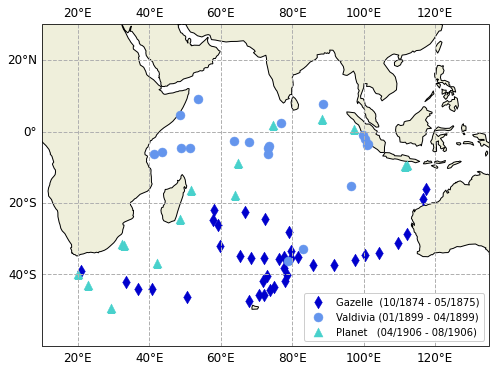

In [ ]:
import matplotlib.patches as mpatches

dsG = ds_0G.groupby('lat').mean()
dsV = ds_0V.groupby('lat').mean()
dsP = ds_0P.groupby('lat').mean()

fig = plt.figure(figsize=(8,10))
ax = plt.subplot(111, projection = ccrs.PlateCarree())
title=''
ax.add_feature(cfeature.LAND, zorder=0, edgecolor='black')
ax.set_xlim([10, 135])
ax.set_ylim([-60, 30])

gl = ax.gridlines(draw_labels=True, linestyle='--', linewidth=1)
gl.xlabel_style = {'size': 12, 'color': 'black'}
gl.ylabel_style = {'size': 12, 'color': 'black'}
gl.right_labels = False
#gl.top_labels = False
  
tempconts = np.arange(0, 36, 2)
labelconts = np.arange(0, 36, 4)

  #print(tempconts)
#cs = ax.contour(WOD.lon, WOD.lat, WOD, tempconts, colors='0.5', linewidths=0.5, zorder=0)
#plt.clabel(cs, labelconts)
symbG = '^'
symbV = 's'
symbP = '^'
symbP = 'o'

symbG = 'd'
symbV = 'o'
symbP = '^'
s = 80
#ax.contourf(bathy.lon, bathy.lat, bathy.elevation)
conts = np.linspace(-6000, 2000, 50)
#ax.contourf(bathy.ETOPO05_X, bathy.ETOPO05_Y, bathy.ROSE,conts, extend='both', cmap=cm.cm.topo)
#points = ax.plot(dsG.lon,dsG.lat, marker=symbG)
#points = ax.plot(dsV.lon,dsV.lat, marker=symbV)
#points = ax.plot(dsP.lon,dsP.lat, marker=symbP)
ec = 'gray'
ec = None
ax.scatter(dsG.lon,dsG.lat, s=s, c='mediumblue', marker=symbG, cmap=cmap,norm=norm, edgecolor=ec, linewidths=0.5, label='Gazelle  (10/1874 - 05/1875)')
ax.scatter(dsV.lon,dsV.lat, s=s, c='cornflowerblue',marker=symbV, cmap=cmap,norm=norm, edgecolor=ec, linewidths=0.5,label='Valdivia (01/1899 - 04/1899)')
ax.scatter(dsP.lon,dsP.lat, s=s, c='mediumturquoise', marker=symbP, cmap=cmap,norm=norm, edgecolor=ec, linewidths=0.5,label='Planet   (04/1906 - 08/1906)')
plt.legend(framealpha=0.95, loc='lower right')#bbox_to_anchor = (1.45,0.175))
  #plt.colorbar(points, fraction = .034, pad = 0.02).set_label(label=u'Change in T (\N{DEGREE SIGN}C)', size=12)
ax.set_title(title, fontsize=14)
#ax.stock_img()

#axHist = ax.inset_axes([0.05, 0.6, 0.15, 0.4])

#bins = [0,500,1000,1500,2000,2500,3000,3500,4000,4500,5000,5500,6000]

#ds_gazelle = cruises_ds.where(cruises_ds.cruise=='Gazelle', drop=True)
#ds_valdivia = cruises_ds.where(cruises_ds.cruise=='Valdivia', drop=True)
#ds_planet = cruises_ds.where(cruises_ds.cruise=='Planet', drop=True)

#pl = ds_planet.Depth.values
#pl[~np.isfinite(pl)] = 0
#all_three = [ds_gazelle.Depth.values, ds_valdivia.Depth.values, pl]
#n, bins, patches = axHist.hist(x=all_three, bins=bins, histtype='barstacked', color=['mediumblue','cornflowerblue','mediumturquoise'], rwidth=0.9, orientation='horizontal')

#print(n)
#print(bins)
#print(patches)

#axHist.set_yticks(bins, fontsize=10)
#axHist.set_xticks(fontsize=12)
#axHist.set_ylabel('Depth (m)', fontsize=14)
#axHist.set_xlabel('Number of Observations', fontsize=14)

#g_patch = mpatches.Patch(color='mediumblue', label='Gazelle Obervations')
#v_patch = mpatches.Patch(color='cornflowerblue', label='Valdivia Observations')
#p_patch = mpatches.Patch(color='mediumturquoise', label='Planet Observations')

#axHist.set_ylim(3000, 0)
#axHist.set_xlim(0,350)

#axHist.grid()

os.environ["CARTOPY_USER_BACKGROUNDS"]  = '/content/drive/My Drive/WOD Historic Data/Jacob Analysis/'

#ax.add_image('/content/drive/My Drive/WOD Historic Data/Jacob Analysis/ShipPictures/BlueMarbleNG-TB_2004-12-01_rgb_720x360.TIFF')
#ax.background_img(name='BM', resolution='high')
#ax.add_feature(cfeature.COASTLINE, edgecolors='w')
#ax.coastlines(color='0.5')




#plt.savefig('/content/drive/My Drive/WOD Historic Data/Jacob Analysis/Figures/OverviewMap.pdf', bbox_inches='tight')

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


[[149.  66.  20.   7.  11.  14.   3.   3.   2.   4.   1.   1.]
 [241.  89.  26.  12.  15.  19.   4.   5.   3.   5.   3.   2.]
 [308. 104.  39.  19.  16.  19.   6.   5.   5.   6.   5.   2.]]
[   0  500 1000 1500 2000 2500 3000 3500 4000 4500 5000 5500 6000]
<a list of 3 Lists of Patches objects>


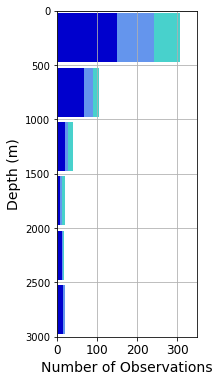

In [ ]:
#### histogram

# want to bin the observations into categories by depth similar to supplementary materials from gebbie/hyubers
#df = cruises_ds.to_dataframe()
import matplotlib.patches as mpatches

bins = [0,500,1000,1500,2000,2500,3000,3500,4000,4500,5000,5500,6000]
#bins = [0, 250, 500, 750, 1000, 1500, 2000, 2500, 3000]
ds_gazelle = cruises_ds.where(cruises_ds.cruise=='Gazelle', drop=True)
ds_valdivia = cruises_ds.where(cruises_ds.cruise=='Valdivia', drop=True)
ds_planet = cruises_ds.where(cruises_ds.cruise=='Planet', drop=True)


plt.figure(figsize=(2.5, 6))
pl = ds_planet.Depth.values
pl[~np.isfinite(pl)] = 0
all_three = [ds_gazelle.Depth.values, ds_valdivia.Depth.values, pl]
n, bins, patches = plt.hist(x=all_three, bins=bins, histtype='barstacked', color=['mediumblue','cornflowerblue','mediumturquoise'], rwidth=0.9, orientation='horizontal')

print(n)
print(bins)
print(patches)

plt.yticks(bins, fontsize=10)
plt.xticks(fontsize=12)
plt.ylabel('Depth (m)', fontsize=14)
plt.xlabel('Number of Observations', fontsize=14)

g_patch = mpatches.Patch(color='mediumblue', label='Gazelle Obervations')
v_patch = mpatches.Patch(color='cornflowerblue', label='Valdivia Observations')
p_patch = mpatches.Patch(color='mediumturquoise', label='Planet Observations')

#plt.legend(handles=[p_patch, v_patch, g_patch], fontsize=12)

plt.grid()
#df_valdivia.groupby(pd.cut(df_valdivia.Depth,bins)).plot(kind='hist')
plt.ylim(3000, 0)
plt.xlim(0,350)

#plt.savefig('/content/drive/My Drive/WOD Historic Data/Jacob Analysis/Figures/Histogram.pdf', bbox_inches='tight')

### BELOW HERE IS NOT USED IN MS

In [ ]:
all_three

[array([151,  67,  20,   8,  12,  14,   3,   3,   2,   4,   1,   1]),
 array([92, 29, 12,  7,  1,  5,  1,  2,  1,  1,  1,  1]),
 array([71., 27.,  7.,  1., nan, nan,  2.,  1.,  1.,  1.,  2., nan])]

In [ ]:
#bathy = xr.open_dataset('https://tds.marine.rutgers.edu/thredds/dodsC/other/bathymetry/GEBCO_2019/GEBCO_2019.nc', decode_times=False).sel(lat=slice(-80, 20), lon=slice(10, 140))
#bathy
bathy = xr.open_dataset('https://data.pmel.noaa.gov/pmel/thredds/dodsC/data/PMEL/etopo5.nc', decode_times=False).sel(ETOPO05_Y=slice(-80, 30), ETOPO05_X=slice(10, 140))

bathy.ROSE.max()

<xarray.DataArray 'ROSE' ()>
array(7010.)

(-0.5, 809.5, 507.5, -0.5)

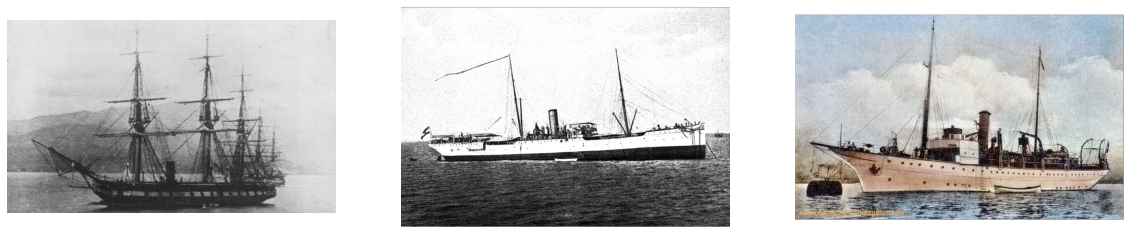

In [ ]:
import matplotlib as mpl

# read image file
with mpl.cbook.get_sample_data(r"/content/drive/My Drive/WOD Historic Data/Jacob Analysis/ShipPictures/Gazelle.jpg") as file:
  G_image = plt.imread(file, format='jpg')
with mpl.cbook.get_sample_data(r"/content/drive/My Drive/WOD Historic Data/Jacob Analysis/ShipPictures/Valdivia.png") as file:
  V_image = plt.imread(file, format='png')
with mpl.cbook.get_sample_data(r"/content/drive/My Drive/WOD Historic Data/Jacob Analysis/ShipPictures/Planet.png") as file:
  P_image = plt.imread(file, format='png')

plt.figure(figsize=(20,10))
ax = plt.subplot(131)
ax.imshow(G_image)
ax.axis('off')
ax = plt.subplot(132)
ax.imshow(V_image)
ax.axis('off')
ax = plt.subplot(133)
ax.imshow(P_image)
ax.axis('off')

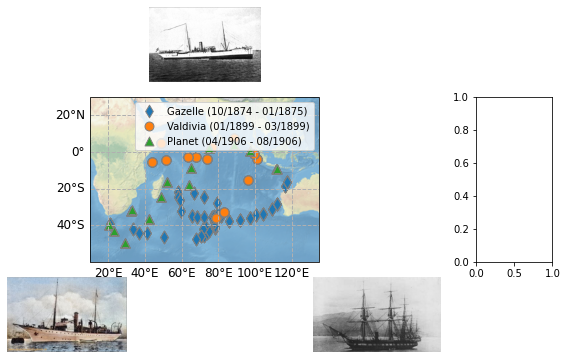

In [ ]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(10,8))

gs = GridSpec(5,8, figure=fig)
#ax = fig.add_subplot(gs[0,0:6])
# identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
#ax1 = fig.add_subplot(gs[0,7])

###############
# MAP 
###############
dsG = ds_0G
dsV = ds_0V
dsP = ds_0P

#fig = plt.figure(figsize=(10,6))
#ax = fig.add_subplot(gs[1:3,0:6])

ax = fig.add_subplot(gs[1:3,0:6], projection=ccrs.PlateCarree())

#ax = plt.subplot(111, projection = ccrs.PlateCarree())
title=''
ax.add_feature(cfeature.LAND, zorder=0, edgecolor='black', facecolor='gray')
ax.set_xlim([10, 135])
ax.set_ylim([-60, 30])

gl = ax.gridlines(draw_labels=True, linestyle='--', linewidth=1)
gl.xlabel_style = {'size': 12, 'color': 'black'}
gl.ylabel_style = {'size': 12, 'color': 'black'}
gl.right_labels = False
gl.top_labels = False
  
tempconts = np.arange(0, 36, 2)
labelconts = np.arange(0, 36, 4)

  #print(tempconts)
#cs = ax.contour(WOD.lon, WOD.lat, WOD, tempconts, colors='0.5', linewidths=0.5, zorder=0)
#plt.clabel(cs, labelconts)
symbG = 'd'
symbV = 'o'
symbP = '^'
s = 80


#points = ax.plot(dsG.lon,dsG.lat, marker=symbG)
#points = ax.plot(dsV.lon,dsV.lat, marker=symbV)
#points = ax.plot(dsP.lon,dsP.lat, marker=symbP)
ax.scatter(dsG.lon,dsG.lat, s=s, marker=symbG, cmap=cmap,norm=norm, edgecolor='gray', label='Gazelle (10/1874 - 01/1875)')
ax.scatter(dsV.lon,dsV.lat, s=s, marker=symbV, cmap=cmap,norm=norm, edgecolor='gray', label='Valdivia (01/1899 - 03/1899)')
ax.scatter(dsP.lon,dsP.lat, s=s, marker=symbP, cmap=cmap,norm=norm, edgecolor='gray', label='Planet (04/1906 - 08/1906)')
plt.legend()
  #plt.colorbar(points, fraction = .034, pad = 0.02).set_label(label=u'Change in T (\N{DEGREE SIGN}C)', size=12)
ax.set_title(title, fontsize=14)
ax.stock_img()


###################
# HISTOGRAM
###################
ax1 = fig.add_subplot(gs[1:3,7])


###################
# IMAGES
##################
# Gazelle
# read image file
with mpl.cbook.get_sample_data(r"/content/drive/My Drive/WOD Historic Data/Jacob Analysis/ShipPictures/Gazelle.jpg") as file:
  G_image = plt.imread(file, format='jpg')
with mpl.cbook.get_sample_data(r"/content/drive/My Drive/WOD Historic Data/Jacob Analysis/ShipPictures/Valdivia.png") as file:
  V_image = plt.imread(file, format='png')
with mpl.cbook.get_sample_data(r"/content/drive/My Drive/WOD Historic Data/Jacob Analysis/ShipPictures/Planet.png") as file:
  P_image = plt.imread(file, format='png')

axP = fig.add_subplot(gs[3,0:2])
axP.imshow(P_image)
axP.axis('off')

axV = fig.add_subplot(gs[0,2:4])
axV.imshow(V_image)
axV.axis('off')

axG = fig.add_subplot(gs[3,4:7])
axG.imshow(G_image)
axG.axis('off')

plt.subplots_adjust( wspace=-0.1)


In [ ]:
gs

GridSpec(2, 4)

In [ ]:
~np.isnat(cruises_ds.where((cruises_ds.cruise=='Valdivia')).Date)

<xarray.DataArray 'Date' (index: 552)>
array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
...
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])
Coordinates:
  * index    (index) int64 10 11 12 13 14 15 16 ... 589 590 591 592 593 594 595

/usr/local/lib/python3.7/dist-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/usr/local/lib/python3.7/dist-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '


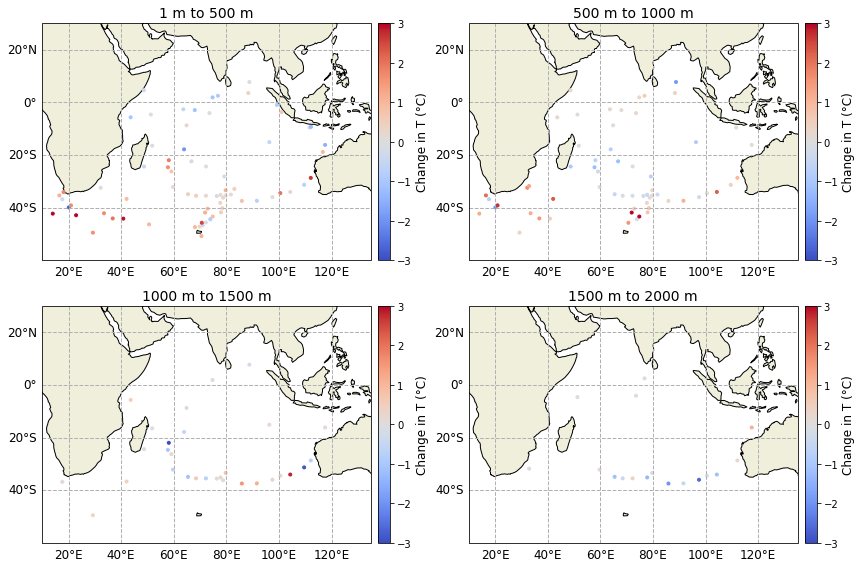

In [ ]:
# plot used in presentation
# 500 meter depth bins excluding the surface

fig = plt.figure(figsize=(12,8))

norm = mpl.colors.Normalize(vmin=-3,vmax=3)
cmap = mpl.cm.coolwarm

#plot_roemmich_ds(ds = bin_0, subplot=221, title='0 m to 500 m', norm=norm, cmap=cmap)

plot_roemmich_ds(ds = bin_0_500, subplot=221, title='1 m to 500 m', norm=norm, cmap=cmap)
plot_roemmich_ds(ds = bin_500_1000, subplot=222, title='500 m to 1000 m', norm=norm, cmap=cmap)
plot_roemmich_ds(ds = bin_1000_1500, subplot=223, title='1000 m to 1500 m', norm=norm, cmap=cmap)
plot_roemmich_ds(ds = bin_1500_2000, subplot=224, title='1500 m to 2000 m', norm=norm, cmap=cmap)

#fig.suptitle('Mean Temperature Difference in 500 m Depth Bins.', y=0.93, fontsize=14)
plt.tight_layout()


/usr/local/lib/python3.7/dist-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/usr/local/lib/python3.7/dist-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '


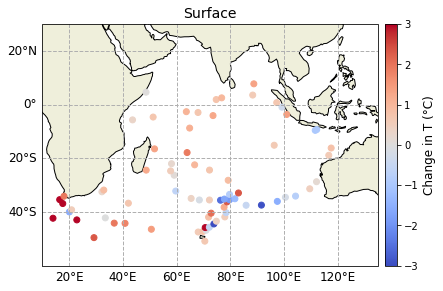

In [ ]:
# surface plot

fig = plt.figure(figsize=(14,10))

norm = mpl.colors.Normalize(vmin=-3,vmax=3)
cmap = mpl.cm.coolwarm

plot_roemmich_ds(ds = bin_0, subplot=221, title='Surface', norm=norm, cmap=cmap)

#plot_roemmich_ds(ds = bin_0_500, subplot=222, title='0 m to 500 m', norm=norm, cmap=cmap)

/usr/local/lib/python3.7/dist-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/usr/local/lib/python3.7/dist-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '


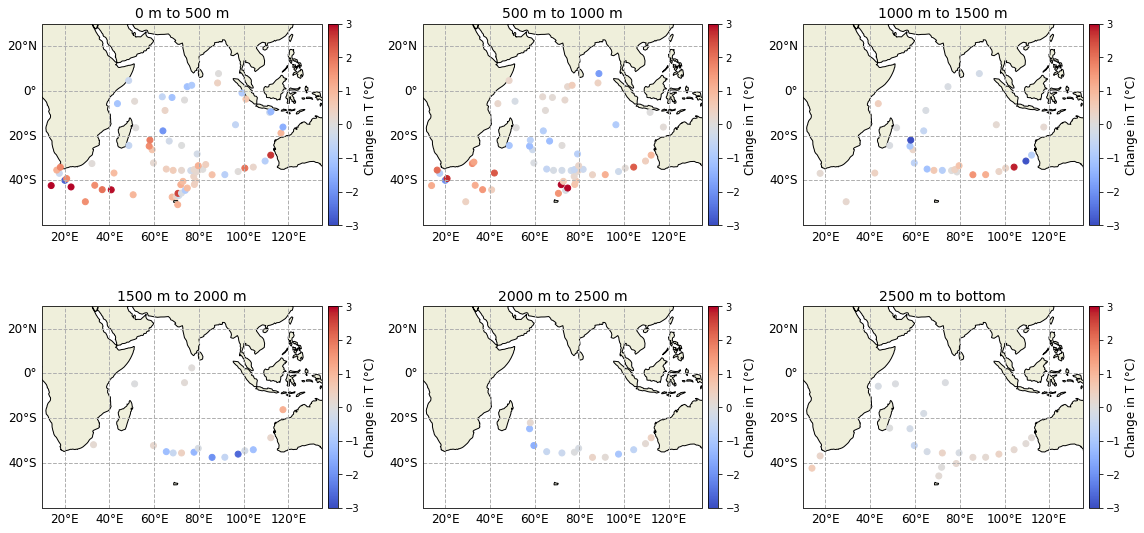

In [ ]:
# 500 meter depth bins from surface to bottom

fig = plt.figure(figsize=(16,8))

norm = mpl.colors.Normalize(vmin=-3,vmax=3)
cmap = mpl.cm.coolwarm

plot_roemmich_ds(ds = bin_0_500, subplot=231, title='0 m to 500 m', norm=norm, cmap=cmap)
plot_roemmich_ds(ds = bin_500_1000, subplot=232, title='500 m to 1000 m', norm=norm, cmap=cmap)
plot_roemmich_ds(ds = bin_1000_1500, subplot=233, title='1000 m to 1500 m', norm=norm, cmap=cmap)
plot_roemmich_ds(ds = bin_1500_2000, subplot=234, title='1500 m to 2000 m', norm=norm, cmap=cmap)
plot_roemmich_ds(ds = bin_2000_2500, subplot=235, title='2000 m to 2500 m', norm=norm, cmap=cmap)
plot_roemmich_ds(ds = bin_2500_bottom, subplot=236, title='2500 m to bottom', norm=norm, cmap=cmap)

#fig.suptitle('Mean Temperature Difference in 500 m Depth Bins.', y=0.93, fontsize=14)
plt.tight_layout()


/usr/local/lib/python3.7/dist-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/usr/local/lib/python3.7/dist-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '


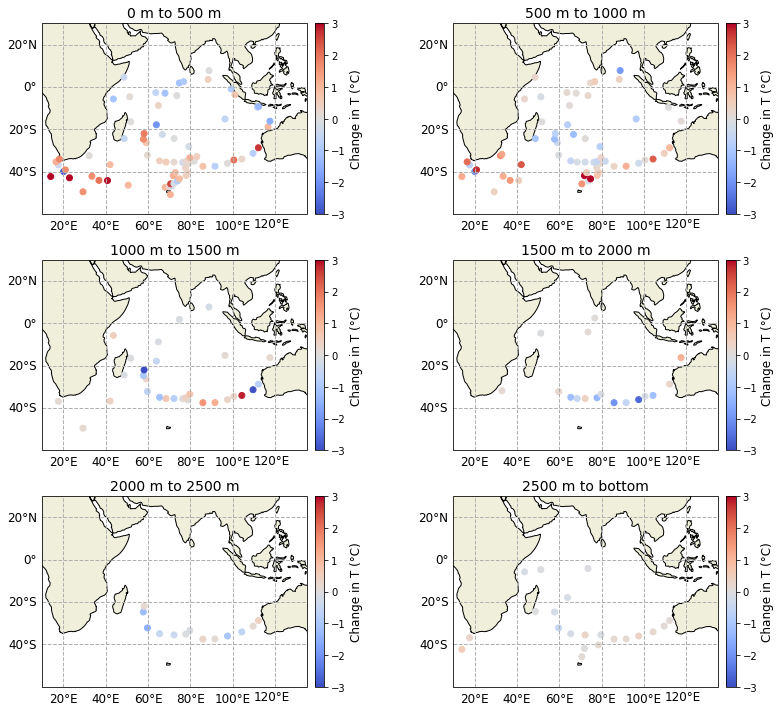

In [ ]:
# vertical orientation

fig = plt.figure(figsize=(12,10))

norm = mpl.colors.Normalize(vmin=-3,vmax=3)
cmap = mpl.cm.coolwarm

plot_roemmich_ds(ds = bin_0_500, subplot=321, title='0 m to 500 m', norm=norm, cmap=cmap)
plot_roemmich_ds(ds = bin_500_1000, subplot=322, title='500 m to 1000 m', norm=norm, cmap=cmap)
plot_roemmich_ds(ds = bin_1000_1500, subplot=323, title='1000 m to 1500 m', norm=norm, cmap=cmap)
plot_roemmich_ds(ds = bin_1500_2000, subplot=324, title='1500 m to 2000 m', norm=norm, cmap=cmap)
plot_roemmich_ds(ds = bin_2000_2500, subplot=325, title='2000 m to 2500 m', norm=norm, cmap=cmap)
plot_roemmich_ds(ds = bin_2500_bottom, subplot=326, title='2500 m to bottom', norm=norm, cmap=cmap)

#fig.suptitle('Mean Temperature Difference in 500 m Depth Bins.', y=0.93, fontsize=14)
plt.tight_layout()

/usr/local/lib/python3.7/dist-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/usr/local/lib/python3.7/dist-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '


,index,Station,Date,Lat degrees,Lat minutes,Lon degrees,Lon minutes,Bottom,Depth,Temperature,Notes,lat,lon,cruise,,Month,WOA_temp_monthly,WOA_temp_seasonal,delta_T_monthly,delta_T_seasonal
46,47,48,1874-12-29,-43.0,-24.0,74.0,48.0,501,549.0,5.0,Note temperature inversion in profile,-43.4,74.8,Gazelle,NaN,12,8.997557,9.187504,3.997557,4.187504


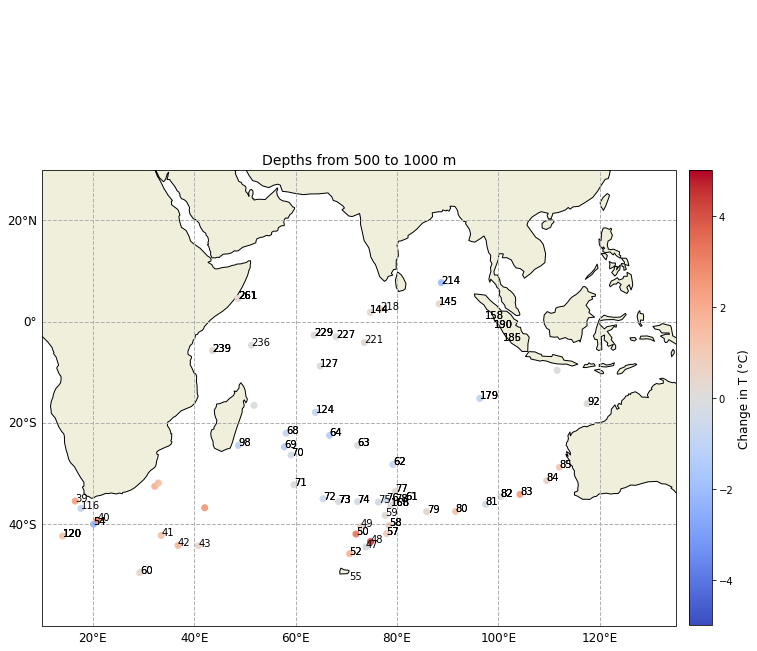

In [ ]:
#labels every station number to find hot an cold spots
# can eaasily change depth bin to take a look at other depths

fig = plt.figure(figsize=(12,12))

norm = mpl.colors.Normalize(vmin=-5,vmax=5)
cmap = mpl.cm.coolwarm

plot_roemmich_ds(ds = bin_500_1000, subplot=111, title='Depths from 500 to 1000 m', norm=norm, cmap=cmap)

labels = depth_500_1000.Station.to_list()

for i in labels:
  lat = depth_500_1000.lat[depth_500_1000.Station==i].iloc[0]
  lon = depth_500_1000.lon[depth_500_1000.Station==i].iloc[0]
  plt.annotate(str(i), (lon, lat))

depth_500_1000[depth_500_1000.Station=='48']

# coldspot = 48 on gazelle

Below are some examples of modern vs historic profile plots from hot/cold spots.

Text(0.5, 0.96, 'COLDSPOT EXAMPLE:\nTemperature with depth of WOA and historic\nobservations from Gazelle station 68.')

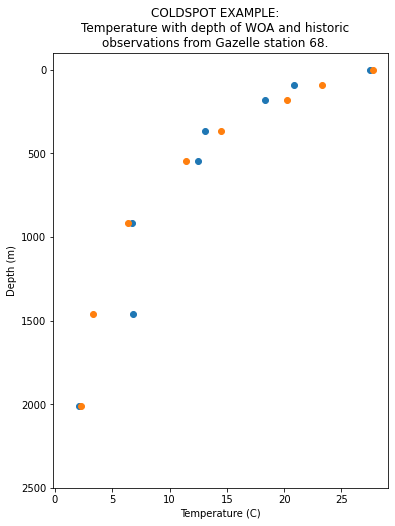

In [ ]:
fig, ax = plt.subplots( figsize=(6,8))

cruises_68 = cruises_df[cruises_df.Station == '68']
cruises_68 = cruises_68[cruises_68.cruise == 'Gazelle']

# historic data
x = cruises_68.Temperature
y = cruises_68.Depth

# WOA data
x1 = cruises_68.WOA_temp_seasonal
y1 = cruises_68.Depth

ax.scatter(x, y, label = 'Historic')
ax.scatter(x1, y1, label = 'WOA')

ax.set_ylim(2500,-100)
ax.set_xlabel('Temperature (C)')
ax.set_ylabel('Depth (m)')

fig.suptitle('COLDSPOT EXAMPLE:\nTemperature with depth of WOA and historic\nobservations from Gazelle station 68.', y=0.96)


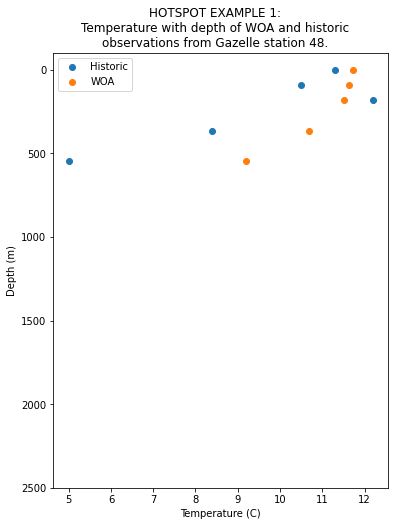

In [ ]:
fig, ax = plt.subplots(figsize=(6,8))

cruises_48 = cruises_df[cruises_df.Station == '48']
cruises_48 = cruises_48[cruises_48.cruise == 'Gazelle']

# historic data
x = cruises_48.Temperature
y = cruises_48.Depth

# WOA data
x1 = cruises_48.WOA_temp_seasonal
y1 = cruises_48.Depth

ax.scatter(x, y, label = 'Historic')
ax.scatter(x1, y1, label = 'WOA')

ax.set_ylim(2500,-100)
ax.set_xlabel('Temperature (C)')
ax.set_ylabel('Depth (m)')

fig.suptitle('HOTSPOT EXAMPLE 1:\nTemperature with depth of WOA and historic\nobservations from Gazelle station 48.', y=0.96)

ax.legend()


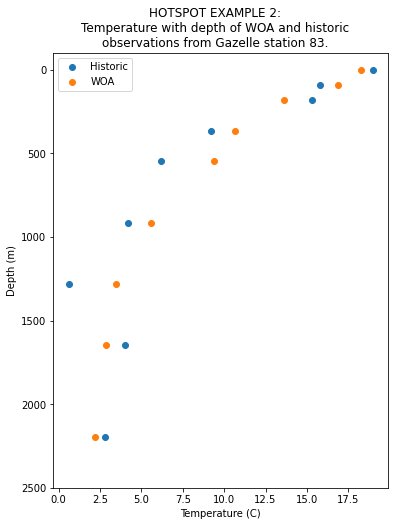

In [ ]:
fig, ax = plt.subplots(figsize=(6,8))

cruises_83 = cruises_df[cruises_df.Station == '83']
cruises_83 = cruises_83[cruises_83.cruise == 'Gazelle']

# historic data
x = cruises_83.Temperature
y = cruises_83.Depth

# WOA data
x1 = cruises_83.WOA_temp_seasonal
y1 = cruises_83.Depth

ax.scatter(x, y, label = 'Historic')
ax.scatter(x1, y1, label = 'WOA')

ax.set_ylim(2500,-100)
ax.set_xlabel('Temperature (C)')
ax.set_ylabel('Depth (m)')

fig.suptitle('HOTSPOT EXAMPLE 2:\nTemperature with depth of WOA and historic\nobservations from Gazelle station 83.', y=0.96)

ax.legend()


The below code uses similar depth ranges at the Roemmich article

In [ ]:
# create averages depth bin datasets

# surface
depth_surface = cruises_df[cruises_df.Depth <= 0]
ds_surface = depth_surface.to_xarray()
bin_surface = ds_surface.groupby('lat').mean()

# 366m
depth_366 = cruises_df[cruises_df.Depth > 0]
depth_366 = depth_366[depth_366.Depth <= 366]
ds_366 = depth_366.to_xarray()
bin_366 = ds_366.groupby('lat').mean()

# 549m
depth_549 = cruises_df[cruises_df.Depth > 366]
depth_549 = depth_549[depth_549.Depth <= 549]
ds_549 = depth_549.to_xarray()
bin_549 = ds_549.groupby('lat').mean()

# 914m
depth_914 = cruises_df[cruises_df.Depth > 549]
depth_914 = depth_914[depth_914.Depth <= 914]
ds_914 = depth_914.to_xarray()
bin_914 = ds_914.groupby('lat').mean()


/usr/local/lib/python3.7/dist-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/usr/local/lib/python3.7/dist-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '


Text(0.5, 0.98, 'Roemmich style plots with similar depth bins to the original article')

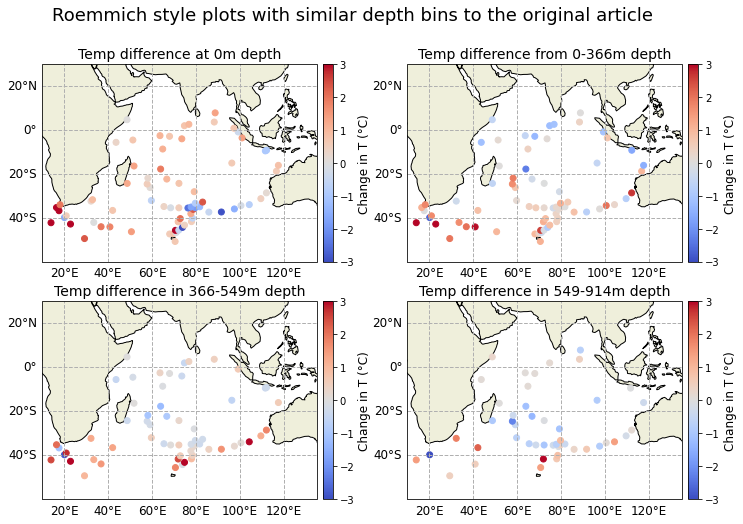

In [ ]:

fig = plt.figure(figsize=(12,8))

norm = mpl.colors.Normalize(vmin=-3,vmax=3)
cmap = mpl.cm.coolwarm

plot_roemmich_ds(ds = bin_surface, subplot=221,title='Temp difference at 0m depth',norm=norm, cmap=cmap)
plot_roemmich_ds(ds = bin_366, subplot=222,title='Temp difference from 0-366m depth',norm=norm, cmap=cmap)
plot_roemmich_ds(ds = bin_549, subplot=223,title='Temp difference in 366-549m depth',norm=norm, cmap=cmap)
plot_roemmich_ds(ds = bin_914, subplot=224,title='Temp difference in 549-914m depth',norm=norm, cmap=cmap)

fig.suptitle('Roemmich style plots with similar depth bins to the original article', fontsize=18)
